In [150]:
import json
from collections import Counter
import pickle
import numpy as np
import pandas as pd
import os
import sys
import argparse
from os.path import dirname, realpath


import math
import hashlib
import datetime
import datetime as datetime
sys.path.append("./src/")

import torch
from torch import nn, optim
from torch.nn import functional as F

from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

from sklearn.base import BaseEstimator
 
sys.path.append(dirname(dirname(realpath(os.getcwd()))))
import matplotlib.pyplot as plt


In [151]:
src_path = "G:\\FillmoreCancerData\\markhe\\VTERisk" 
src_path2 = "G:\\FillmoreCancerData\\markhe\\VTERisk - Copy" 

def md5(key):
    return hashlib.md5(repr(key).encode()).hexdigest()
testDF = pd.read_csv(os.path.join(src_path2, 'Notebooks/Find/fixed_dx.csv'))
pat_ids = (testDF['patient_id'] ).astype(int)
testDF['pids'] = pat_ids.apply(md5)

In [152]:
logpath = os.path.join(src_path ,'logs_transformer_vte/H/11_7/', "d93e7956f15305ad23c78d6884ca2816.results.dev_preds")

In [153]:
def compute_calibration_curve(golds_for_eval,Probs_for_eval):
    prob_true, prob_pred = calibration_curve(golds_for_eval, Probs_for_eval, n_bins=20)
    return prob_true, prob_pred


In [154]:
def get_4Ms(M):
    M1 = M.drop_duplicates(['patient_id'])
    m0 = M.duplicated(['patient_id'])
    M234 = M[m0]
    M2 = M234.drop_duplicates(['patient_id'])

    m00 = M234.duplicated(['patient_id'])
    M34 = M234[m00]
    M3 = M34.drop_duplicates(['patient_id'])

    m000 = M34.duplicated(['patient_id'])
    M4 = M34[m000]
    return M1, M2, M3, M4

In [155]:
tdf = pd.DataFrame({'patient_id': (testDF['patient_id'] ),    
                    'pids': (testDF['pids'] ),    
                  'dob': (testDF['dob'] ),  
                  'outcome_date': (testDF['outcome_date'] ), 
                  'obs_time_end': (testDF['obs_time_end'] ),  
                  'index_date': (testDF['index_date'] ),  
                  'diag_date': (testDF['diag_date'] ),  
                  'outcome': (testDF['outcome'])    })

In [156]:
with open(logpath, 'rb') as f:
    R = pickle.load(f)
    p = np.array(R['probs'])

Df = pd.DataFrame.from_dict(R)
Df['probs'] = Df['probs'].astype(float)
Df['exams'] = Df['exams'].astype(int)
M = pd.merge(tdf, Df)
M1, M2, M3, M4 = get_4Ms(M)

In [157]:
logpath = os.path.join(src_path ,'logs_transformer_vte/H/11_7/', "d93e7956f15305ad23c78d6884ca2816.results.test_preds")
with open(testpath, 'rb') as f:
    R_t = pickle.load(f)
Df_test = pd.DataFrame.from_dict(R_t)
Df_test['probs'] = Df_test['probs'].astype(float)
M_test = pd.merge(tdf, Df_test)
M_test1, M_test2, M_test3, M_test4 = get_4Ms(M_test)

In [115]:
def logit (p): return np.log(  p / (1 - p) )
def expit (p): return  1/(1 + np.exp(-p))


In [116]:
def platt_0 (y_prob, y_true, p_test):
    logistic = LogisticRegression(C=1e4, solver='lbfgs', fit_intercept = False)
    logistic.fit(y_prob.reshape(-1,1), y_true)
    coef_ = logistic.coef_[0]
    fit = p_test * coef_[0] 
    out = 1 / (1 + np.exp(-fit))
    return  out

In [117]:
def platt (y_prob, y_true, p_test):
    logistic = LogisticRegression(C=1e4, solver='lbfgs')
    logistic.fit(y_prob.reshape(-1,1), y_true)
    coef_ = logistic.coef_[0]
    intercept_ = logistic.intercept_
    fit = p_test * coef_[0] + intercept_
    out = 1 / (1 + np.exp(-fit))
    return  out

In [118]:
mp0 = np.array(M['probs'])
mp1 = np.array(M1['probs'])
mp2 = np.array(M2['probs'])
mp3 = np.array(M3['probs'])
mp4 = np.array(M4['probs'])

In [119]:
tp0 = np.array(M_test['probs'])
tp1 = np.array(M_test1['probs'])
tp2 = np.array(M_test2['probs'])
tp3 = np.array(M_test3['probs'])
tp4 = np.array(M_test4['probs'])

In [120]:
gold0 =   np.array(M['golds'],dtype = int)
gold1 =   np.array(M1['golds'],dtype = int)
gold2 =   np.array(M2['golds'],dtype = int)
gold3 =   np.array(M3['golds'],dtype = int)
gold4 =   np.array(M4['golds'],dtype = int)

In [121]:
tgold1 =   np.array(M_test1['golds'],dtype = int)
tgold2 =   np.array(M_test2['golds'],dtype = int)
tgold3 =   np.array(M_test3['golds'],dtype = int)
tgold4 =   np.array(M_test4['golds'],dtype = int)
tgold =   np.array(M_test['golds'],dtype = int)

In [122]:
def get_coef (y_prob, y_true, p_test):
    logistic = LogisticRegression(C=1e4, solver='lbfgs')
    logistic.fit(y_prob.reshape(-1,1), y_true)
    coef_ = logistic.coef_[0]
    intercept_ = logistic.intercept_
    fit = p_test * coef_[0] + intercept_
    return  coef_ , intercept_

In [123]:
logistic = LogisticRegression(C=1e4, solver='lbfgs')
logistic.fit(  logit(mp0).reshape(-1,1),  np.array(M['golds'],dtype = int))
[logistic.coef_[0], logistic.intercept_]

[array([1.10417266]), array([-1.94169307])]

## global coeff

In [124]:
logistic = LogisticRegression(C=1e4, solver='lbfgs', fit_intercept = False)
logistic.fit(  logit(mp0).reshape(-1,1),  np.array(M['golds'],dtype = int))
logistic.coef_[0]

array([2.37310322])

In [125]:
def platt_global (y_prob, y_true, p_test):
    logistic = LogisticRegression(C=1e4, solver='lbfgs')
    logistic.fit(y_prob.reshape(-1,1), y_true)
    coef_ = logistic.coef_[0]
    fit = p_test * coef_[0]  - 1.94169
    out = 1 / (1 + np.exp(-fit))
    return  out

In [126]:
cal1 =platt_0 (logit(mp1),  np.array(M1['golds'],dtype = int), logit (tp1 ))
cal2 =platt_0 (logit(mp2),  np.array(M2['golds'],dtype = int), logit (tp2 ))
cal3 =platt_0 (logit(mp3),  np.array(M3['golds'],dtype = int), logit (tp3) )
cal4 =platt_0 (logit(mp4),  np.array(M4['golds'],dtype = int), logit (tp4) )
cal0 =platt_0 (logit(mp0),  np.array(M['golds'],dtype = int), logit (tp0) )


In [127]:
cal0 =platt (np.array(M['probs']), np.array(M ['golds'],dtype = int),  M_test ['probs']  )

In [128]:
cal1 =platt_global (mp1,  np.array(M1['golds'],dtype = int), tp1 )
cal2 =platt_global (mp2,  np.array(M2['golds'],dtype = int),  tp2 )
cal3 =platt_global (mp3,  np.array(M3['golds'],dtype = int),  tp3 )
cal4 =platt_global (mp4,  np.array(M4['golds'],dtype = int), tp4  )


(array([3928., 3292., 2726., 2214., 1627., 1118.,  662.,  325.,  114.,
          19.]),
 array([0.1368677 , 0.19712661, 0.25738552, 0.31764443, 0.37790333,
        0.43816224, 0.49842115, 0.55868006, 0.61893897, 0.67919788,
        0.73945678]),
 <BarContainer object of 10 artists>)

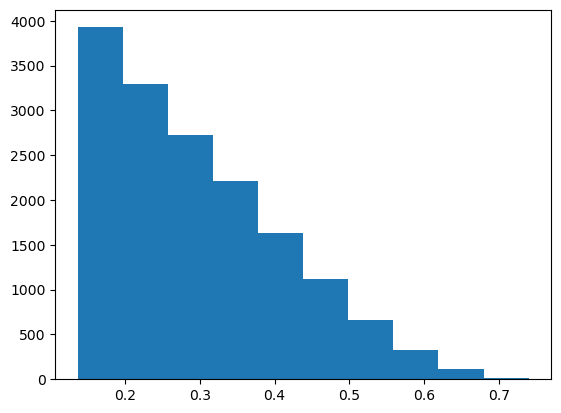

In [129]:
plt.hist( (cal1))

In [130]:
y1, p1 = compute_calibration_curve(M_test1['golds'], cal1 )
y2, p2 = compute_calibration_curve(M_test2['golds'], cal2 )
y3, p3 = compute_calibration_curve(M_test3['golds'], cal3 )
y4, p4 = compute_calibration_curve(M_test4['golds'], cal4 )


In [131]:
y0, p0 = compute_calibration_curve(M_test['golds'], cal0 )


In [132]:
import matplotlib.pyplot as plt

def plotter (p_i, y_i):
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot(p_i, y_i, 's-')
    ax1.plot([0, 1], [0, 1], linestyle='--', 
             color='grey', label='random guess (AUROC: 0.500)')
    ax2.hist(p_i, bins=10, range=(0, 1))
    ax1.set_xlim([-0.01, 1.01])
    ax1.set_ylim([-0.01, 1.01])
    ax1.set_xlabel('Predicted value')
    ax1.set_ylabel('Fraction of positive')
    ax1.set_title("Calibration plot")
    ax2.set_xlabel('Prediction probability')
    ax2.set_ylabel('Count')
    plt.tight_layout()
    

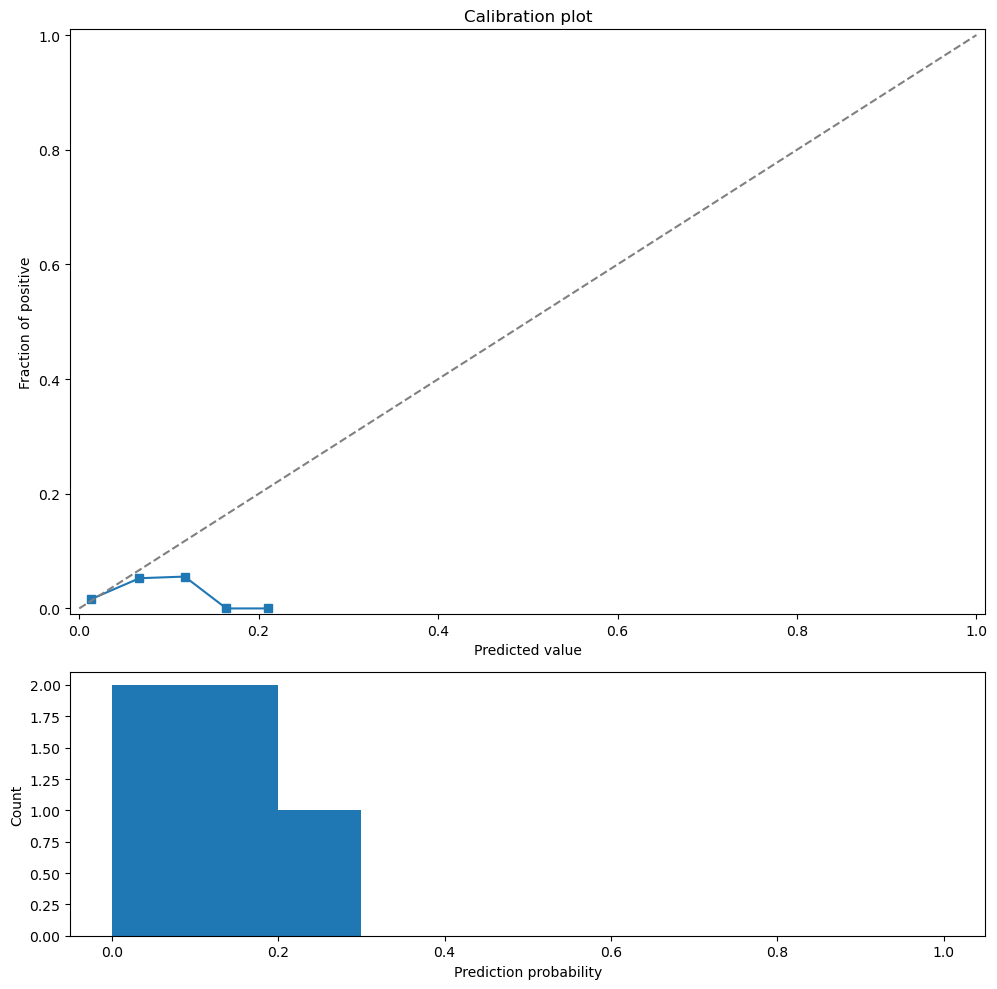

In [133]:
plotter(p0, y0)

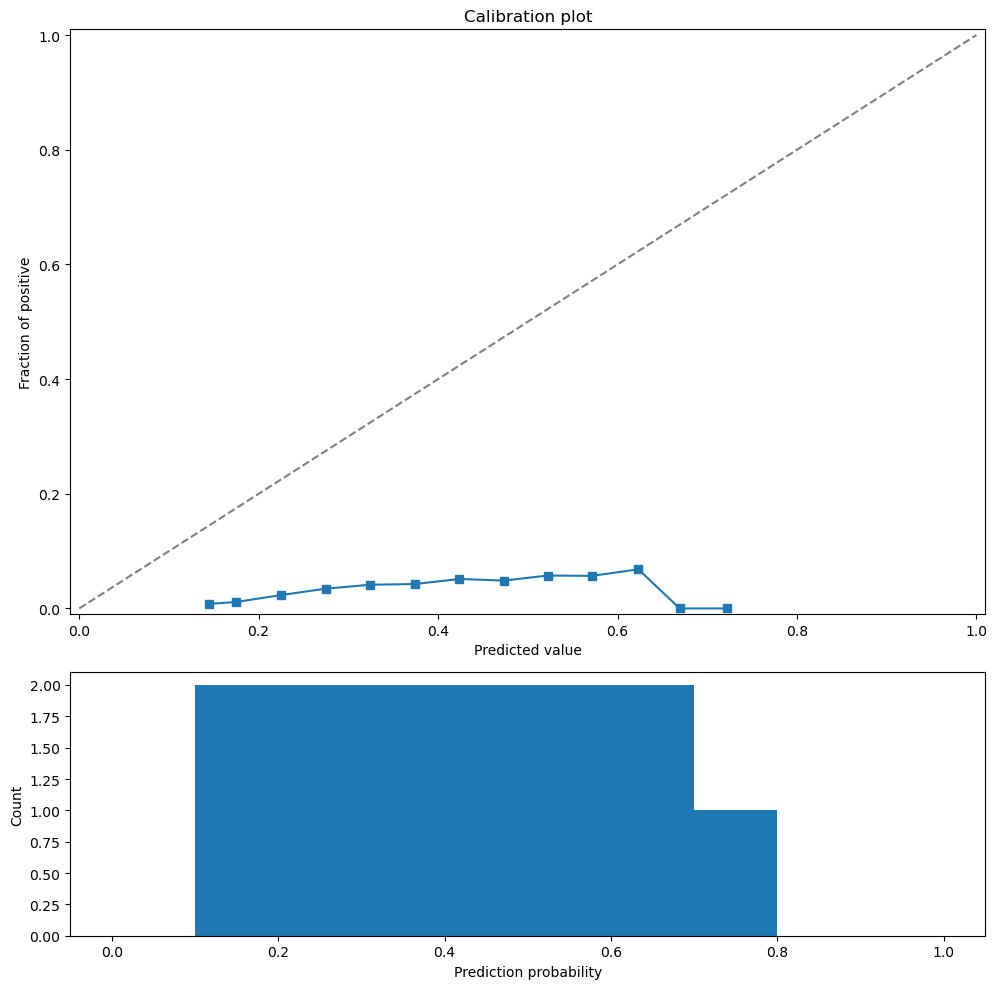

In [134]:
plotter(p1, y1)

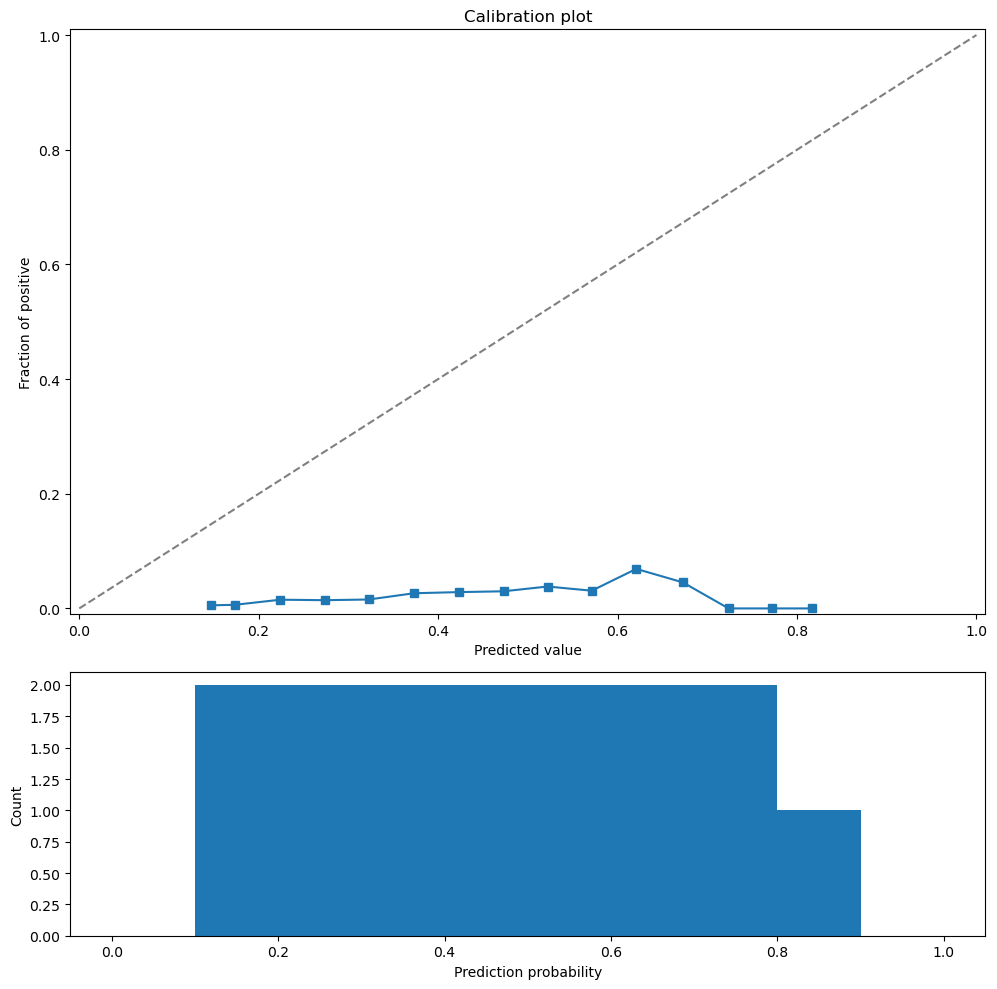

In [135]:
plotter(p2, y2)

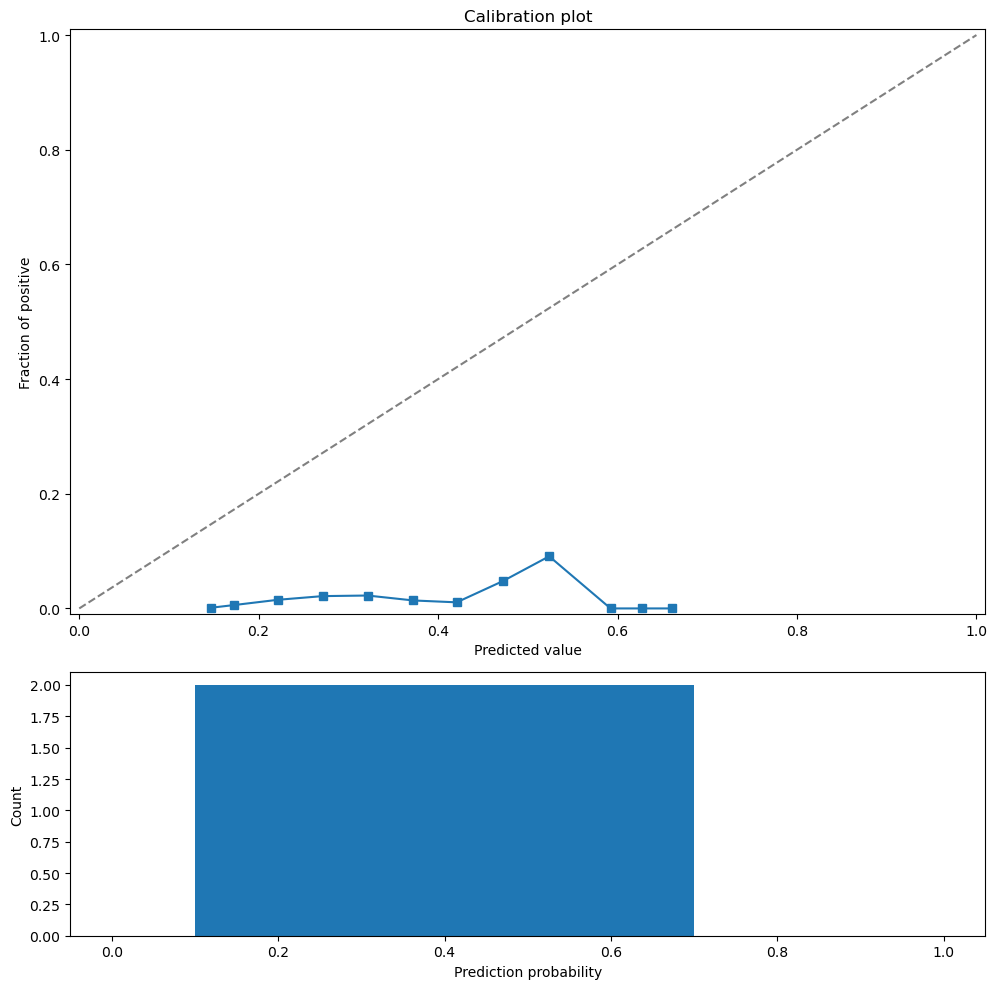

In [136]:
plotter(p3, y3)

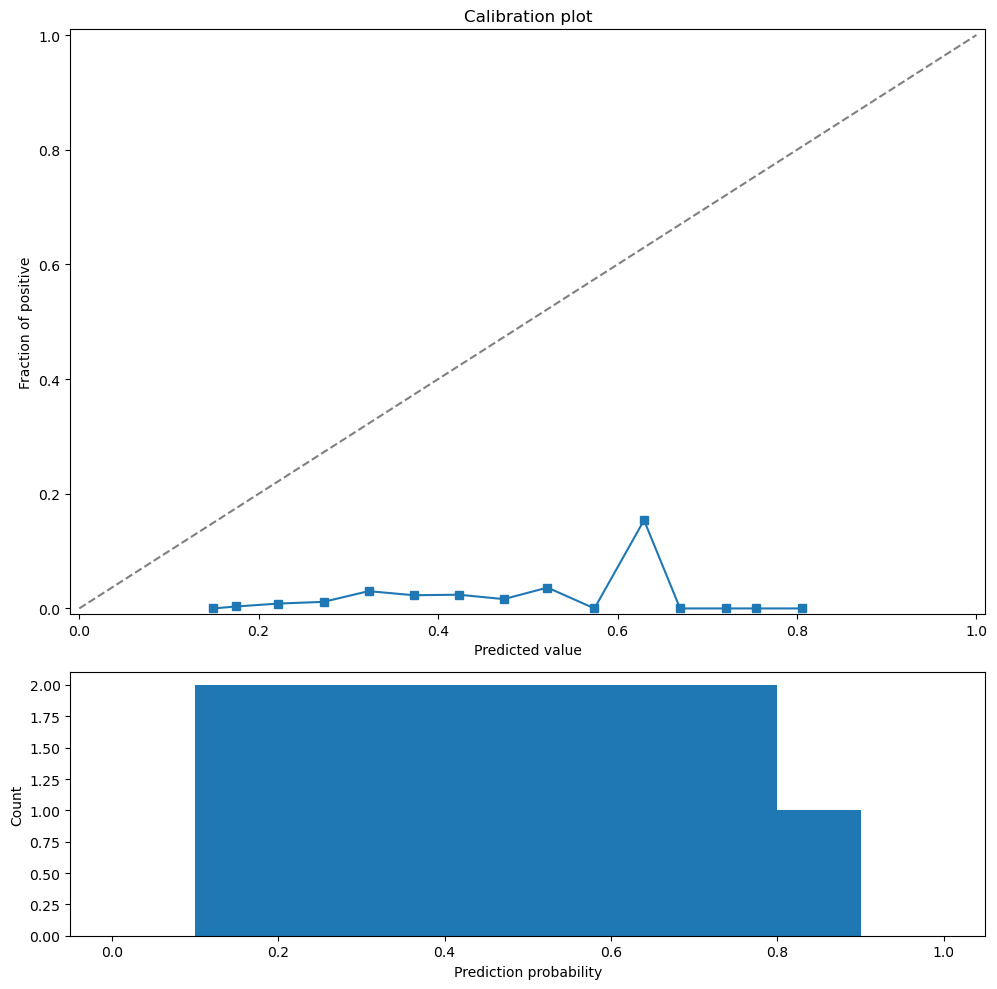

In [137]:
plotter(p4, y4)

In [138]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_auc_score

In [139]:
tgold


array([0, 0, 0, ..., 0, 0, 0])

In [140]:
roc_auc_score(tgold, tp0, average = 'samples')


0.7149298464901765

In [141]:
roc_auc_score(tgold1, tp1, average = 'samples')


0.6480031999535442

In [142]:
roc_auc_score(tgold2, tp2, average = 'samples')


0.6455460267776995

In [143]:
roc_auc_score(tgold3, tp3, average = 'samples')


0.6854529873329583

In [144]:
roc_auc_score(tgold4, tp4, average = 'samples')


0.7072423069302404

In [145]:
( confusion_matrix (tgold4  , cal4>.5) )

array([[10593,   119],
       [   94,     4]], dtype=int64)

In [146]:
( confusion_matrix (tgold3 , cal3>.5) )

array([[12432,    15],
       [  131,     1]], dtype=int64)

In [147]:
( confusion_matrix (tgold2 , cal2>.5) )

array([[13549,   306],
       [  187,    12]], dtype=int64)

In [148]:
( confusion_matrix (tgold1, cal1>.5) )

array([[14483,  1036],
       [  445,    61]], dtype=int64)

In [149]:
# how many people had event within 6 months of index date

In [27]:
m1.to_csv('output/XCoh_Sen.csv') 

In [34]:
#m1.to_excel('output/dxMD_Sensitivity90.xlsx') 

In [39]:
y1 = np.array(M1['golds'],dtype = int)
x1 = M1['probs'].to_numpy()
platt.fit(x1, y1)
cal_1 = platt.predict(M_test1['probs'])